Equipo conformado por:
+ Samuel Perez Cano
+ Juan Esteban rave
+ Diego Alejandro Ramirez

0. Semilla y Librerias necesarias

In [17]:
# Simulación Monte Carlo del caso “Combo café + snack”
# Requisitos: numpy, pandas, scipy, matplotlib (opcional para gráficos)
import numpy as np
import pandas as pd
from scipy.stats import truncnorm, triang, beta, spearmanr
import matplotlib.pyplot as plt
RNG_SEED = 42
np.random.seed(RNG_SEED)
N = 10000  # iteraciones

1. Funciones rpert y rtruncnorm

In [16]:
# --- 1) Funciones auxiliares ---
def rpert(size, mini, mode, maxi, lamb=4):
    # Beta-PERT
    a = 1 + lamb * (mode - mini) / (maxi - mini) # Calcula el parametro a para la distribucion beta basado en los argumentos
    b = 1 + lamb * (maxi - mode) / (maxi - mini) # Calcula el parametro b para la distribucion beta basado en los argumentos
    x = beta.rvs(a, b, size=size) # Genera numeros aleatorios para la distribucion beta usando las variables a y b
    return mini + x * (maxi - mini) # Returna la distribucion beta x y la cambia con el rango dfinido por maxi y el mini, en otras palabras reemplaza los valores entre 0,1 de la distribucion beta estandar por los valores que estan entre mini y maxi

In [18]:
def rtruncnorm(size, mean, sd, low, high):
    a, b = (low - mean) / sd, (high - mean) / sd #Calcula dos limites a(Minimo) y b(Maximo) para la distribucion normal truncada
    return truncnorm.rvs(a, b, loc=mean, scale=sd, size=size)

2. Variables de entrada

In [19]:
# --- 2) Muestras de entradas ---
D = rpert(N, 6000, 8000, 11000) # Valores fijos de la demanda
P = rtruncnorm(N, mean=9000, sd=400, low=8000, high=10000)  # Diferentes alternativas del precio
CV = triang.rvs(c=(4800-4400)/(5300-4400), loc=4400, scale=(5300-4400), size=N)  # Diferentes Costo unitario
CF = np.random.uniform(17_000_000, 19_500_000, size=N) # Diferentes Costos fijos


3. Variables de salida

In [20]:
# --- 3) Salidas ---
Ingreso = D * P #Calculo de los ingresos
CostoVar = D * CV #Calculo de los costos
Utilidad = Ingreso - CostoVar - CF #Calculo de la utilidad

4. Resumen de las metricas

In [21]:
# --- 4) Métricas ---
#Funcion para calcular Media, Desviacion y los percentiles 5%, 50% Y 95% de la distribucion truncada(x)
def summary_stats(x):
    return {
        "media": np.mean(x),
        "std": np.std(x, ddof=1),
        "P5": np.percentile(x, 5),
        "P50": np.percentile(x, 50),
        "P95": np.percentile(x, 95)
    }

stats_u = summary_stats(Utilidad) # Este varible contiene el resumen de las metricas de la funcion como resultado de la utildidad y su probabilidad de ocurrencia
prob_perdida = np.mean(Utilidad < 0) #Calcula la probabilidad de perdidad como media de la utilidad para valores donde la utilidad sea menor a 0
VaR_5 = np.percentile(Utilidad, 5) # Calcula el valor e riesgo al 5% buscando los valores de utilidad menores al 5% de probabilidad de los resultados de la simulacion, en otras palabras es la perdida maxima que se esperaria

#Este ciclo muestra el resumen de las metricas de la distribucion de probabilidades de la utilidad
print("=== Resumen Utilidad ===")
for k, v in stats_u.items():
    print(f"{k:>5}: {v:,.0f}")
print(f"Prob. pérdida: {prob_perdida:.2%}")
print(f"VaR(5%): {VaR_5:,.0f}")

=== Resumen Utilidad ===
media: 15,757,106
  std: 5,234,558
   P5: 7,628,439
  P50: 15,498,021
  P95: 24,859,443
Prob. pérdida: 0.00%
VaR(5%): 7,628,439


5. Sensibilidad

In [22]:
# --- 5) Sensibilidad (Spearman) ---
inputs = np.column_stack([D, P, CV, CF]) #Crea una columna para cada una de las varaibles de entrada
labels = ["Demanda (D)", "Precio (P)", "Costo unit (CV)", "Costos fijos (CF)"] #Los nombres de cada una de las columnas
rho = [spearmanr(inputs[:, i], Utilidad).correlation for i in range(inputs.shape[1])] #Calcula el coeficiente de correlacion de rango de spearman para cada una de las columnas de matriz anterior inputs
sens = pd.DataFrame({"Variable": labels, "Spearman_rho": rho}).sort_values("Spearman_rho") #Crea un dataframe conn 2 columnas que almacenan los valores de las correlaciones con los nombres de las columnas
print("\n=== Sensibilidad (Spearman) ===") #Imprime el enunciado
print(sens) #Imprime el dataframe


=== Sensibilidad (Spearman) ===
            Variable  Spearman_rho
2    Costo unit (CV)     -0.262535
3  Costos fijos (CF)     -0.137801
1         Precio (P)      0.565302
0        Demanda (D)      0.733405


6. Resultados y grafico

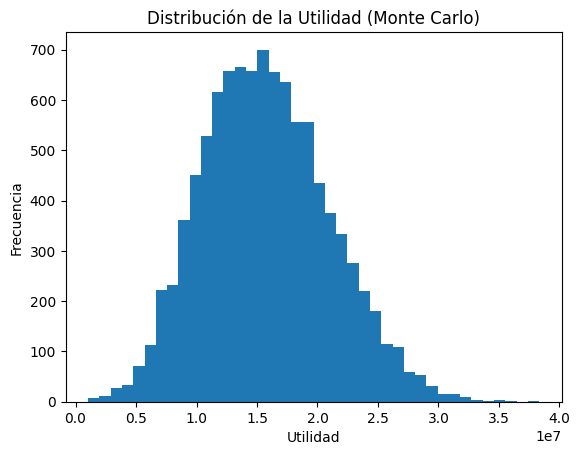

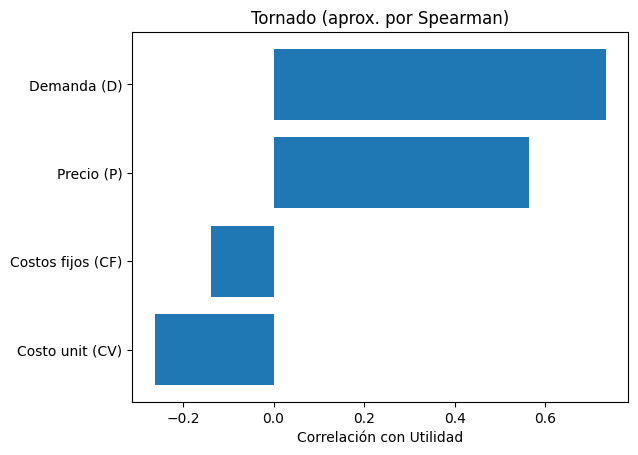

In [23]:
# --- 6) Gráficos---
plt.figure() #Configura la figura para el grafico
plt.hist(Utilidad, bins=40) #Genera el histograma con los valores de la utilidad
plt.title("Distribución de la Utilidad (Monte Carlo)") #Titulo del grafico
plt.xlabel("Utilidad"); plt.ylabel("Frecuencia") #Nombres de los ejes x y y del grafico
plt.show() #Imprimir el grafico
plt.figure() #Configura la figura para el grafico
plt.barh(sens["Variable"], sens["Spearman_rho"])  #Genera el grafico de tornado con los valores de la utilidad
plt.title("Tornado (aprox. por Spearman)") #Titulo del grafico
plt.xlabel("Correlación con Utilidad") #Titulo del eje x
plt.show() #Imprimir el grafico

##**Conclusiones del analisis**
1. La Utilidad Esperada es Positiva y Significativa: El resumen de las métricas muestra que la "media" de la utilidad es de aproximadamente 15.757.106. Esto sugiere que, en promedio, se espera que el combo "café + snack" sea rentable bajo las suposiciones y distribuciones de entrada definidas.
2. Bajo Riesgo de Pérdida: La "Prob. pérdida" es del 0.00%. Esto indica que, según la simulación, la probabilidad de que la utilidad sea negativa (es decir, tener pérdidas) es extremadamente baja o nula dentro de las 10,000 iteraciones simuladas. Esto sugiere un escenario de negocio robusto frente a la incertidumbre modelada.
3. Existe una Variabilidad Considerables en la Utilidad: La desviación estándar ("std") de la utilidad es de aproximadamente 5.234.558. Esto muestra que, aunque la utilidad promedio es positiva, hay una dispersión significativa en los posibles resultados de utilidad. La utilidad real podría variar considerablemente de la media esperada. El histograma de la utilidad visualiza esta dispersión.
4. La Demanda y el Precio son los Factores de Mayor Influencia (Positiva): El gráfico de Tornado y la tabla de sensibilidad (Spearman) muestran que la "Demanda (D)" tiene la correlación positiva más alta (0.733), seguida por el "Precio (P)" (0.565). Esto significa que las variaciones en la Demanda y el Precio son los que más influyen en la Utilidad, y lo hacen en una dirección positiva (mayor Demanda o Precio tienden a resultar en mayor Utilidad).
5. El Costo Unitario y los Costos Fijos Tienen un Impacto Negativo Menor: El "Costo unitario (CV)" y los "Costos fijos (CF)" tienen correlaciones negativas con la Utilidad (-0.263 y -0.138 respectivamente). Esto indica que un aumento en estos costos tiende a disminuir la Utilidad, pero su impacto es menor en magnitud comparado con el impacto positivo de la Demanda y el Precio. El gráfico de Tornado muestra visualmente que las barras para los costos son más cortas que las de Demanda y Precio.
6. El VaR(5%) Proporciona un Umbral de Utilidad Mínima Esperada: El Valor en Riesgo al 5% ("VaR(5%)") es de aproximadamente 7.628.439. Esto significa que, en el 95% de los escenarios simulados, la utilidad esperada fue igual o superior a 7.628.439. Este valor sirve como una estimación de la utilidad mínima que se podría esperar en condiciones "normales" (excluyendo el 5% de los peores casos).
Estas conclusiones te dan una buena idea del potencial de rentabilidad del combo, los principales impulsores de esa rentabilidad y el nivel de riesgo asociado (que parece bajo en términos de probabilidad de pérdida total, pero con variabilidad en la utilidad).